In [1]:
import pandas as pd
import json
import en_core_web_sm
import spacy
import gensim.parsing.preprocessing
import pprint

In [2]:
input_path = '../../data/data_2021-02-01 22:27:13.862993.json'
output_path = '../../data/'

In [3]:
with open(input_path, encoding="utf-8") as f:
    data = json.load(f)
# Keywords from every paper  
keywords_df = pd.json_normalize(data['papers'])['keywords']

print("No of papers: {}".format(keywords_df.shape[0]))

No of papers: 2230


In [4]:
nlp = spacy.load("en_core_web_sm")
STOPWORDS = nlp.Defaults.stop_words

In [5]:
def process(flat_words, lemmatize=True, min_word_len=2):
  flat_words = [gensim.parsing.preprocessing.strip_non_alphanum(word) for word in flat_words]
  doc = spacy.tokens.Doc(nlp.vocab, words=flat_words)

  processed = []

  if lemmatize:
    processed = [token.lemma_ for token in doc]
    processed = [token.lower() for token in processed]
  else:
    processed = [token.lower_ for token in doc]

  processed = [token for token in processed if token not in STOPWORDS]
  processed = [token for token in processed if len(token) >= min_word_len]

  return processed


In [6]:
def process_corpus(keywords_df, lemmatize=True, min_word_len=2):
  processed_corpus = []
  flat_words = []

  # n: no of research papers
  # [[kw11, kw12, ...] ...[kwn1, kwn2, kwn3, ...]]
  keywords = keywords_df.tolist()
  # j: no of document in which the keyword is present
  # kwji -> [wji1, wij2, ...] ~ list of all words associated with keyword i of paper j
  # [kwj1, kwj2, ...] -> [kwj11, kwj12, wkwj13, kwj21, kwj22, ...] ~ list of all words associated with the keywords of paper j
  for l in keywords:
    tmp = []
    for keyword in l:
      words = keyword.split(" ")
      for word in words:
        tmp.append(word)
    flat_words.append(tmp)

  for l in flat_words:
    processed_corpus.append(process(l, True, 2))

  return processed_corpus


In [7]:
from gensim import corpora

processed_corpus = process_corpus(keywords_df)
dictionary = corpora.Dictionary(processed_corpus)

bow_corpus = [dictionary.doc2bow(words) for words in processed_corpus]


In [8]:
from gensim import models

# Train the model
tfidf = models.TfidfModel(bow_corpus)

In [9]:
from gensim import similarities

index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=len(dictionary.token2id))

In [10]:
from collections import defaultdict

def compute_similarities(processed_corpus, threshold=0.9):
  similarities = defaultdict(list)

  for query_doc_index in range(len(processed_corpus)):
    query_doc =  processed_corpus[query_doc_index]
    query_bow = dictionary.doc2bow(query_doc)
    sims = index[tfidf[query_bow]]
    for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True):
      if score >= threshold and document_number != query_doc_index:
        similarities[query_doc_index].append((document_number, score))

  return similarities


In [11]:
# Compute similarites between every two papers
sims = compute_similarities(processed_corpus, 0.0)

In [12]:
from collections import Counter
from math import floor
from tqdm import tqdm

avg_ws_thr = [0] * 11

last_mean = [0] *  11

for item in tqdm(sims.items()):
  curr_paper_ws = processed_corpus[item[0]]
  for paper in item[1]:
    if paper[0] > item[0]: 
      thr = (int) (floor(paper[1] * 10))
      paper_ws = processed_corpus[paper[0]]
      inter = list((Counter(curr_paper_ws) & Counter(paper_ws)).elements())
      last_mean[thr] += 1
      # Calculate rolling mean
      avg_ws_thr[thr] = avg_ws_thr[thr] + (len(inter) - avg_ws_thr[thr]) / last_mean[thr]

for thr in range(10):
  print("a 0.{}% similarity between papers coresponds to {} common words".format(thr, avg_ws_thr[thr]))
print("a 1.0% similarity between papers coresponds to {} common words".format(thr, avg_ws_thr[10]))

100%|██████████| 2230/2230 [00:34<00:00, 63.91it/s] 

a 0.0% similarity between papers coresponds to 0.2926255174554257 common words
a 0.1% similarity between papers coresponds to 2.0650985322495887 common words
a 0.2% similarity between papers coresponds to 2.899430443941645 common words
a 0.3% similarity between papers coresponds to 3.64901764901765 common words
a 0.4% similarity between papers coresponds to 4.3540856031128445 common words
a 0.5% similarity between papers coresponds to 5.097959183673468 common words
a 0.6% similarity between papers coresponds to 6.199999999999999 common words
a 0.7% similarity between papers coresponds to 7.933333333333334 common words
a 0.8% similarity between papers coresponds to 7.4 common words
a 0.9% similarity between papers coresponds to 10.2 common words
a 1.0% similarity between papers coresponds to 9 common words


In [13]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

dist = cosine_distances(index)

Estimated number of clusters: 38


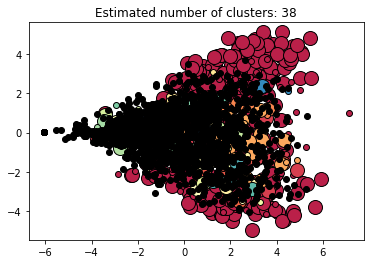

In [14]:
db = DBSCAN(
        eps=0.3,
        min_samples=3,
        metric='precomputed',
        algorithm='brute').fit(dist)

labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

#  Perform dimensional reduction of the distance matrix with PCA
X = PCA(n_components=2).fit_transform(dist) 

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [15]:

#clustered_papers = pd.DataFrame({'words': processed_corpus, 'cluster': db.labels_}, columns=['words', 'cluster'])
print('../../data/' + '{}_labeled.json'.format(input_path.split('/')[-1][:-5]))

../../data/data_2021-02-01 22:27:13.862993_labeled.json


In [16]:
# Write labeled papers to json
clustered_papers = []
keys = ['words', 'cluster']

for i in range(len(processed_corpus)):
    vals = [processed_corpus[i], int(db.labels_[i])]
    clustered_papers.append(dict(zip(keys, vals)))


with open('../../data/' + '{}_labeled.json'.format(input_path.split('/')[-1][:-5]), 'w') as f:
        json.dump({'clustered_papers':clustered_papers}, f, ensure_ascii=False, indent=4)




In [17]:
clustered_papers = pd.DataFrame({'words': processed_corpus, 'cluster': db.labels_}, columns=['words', 'cluster'])

Text(0.5, 1.0, 'No of Words/Paper')

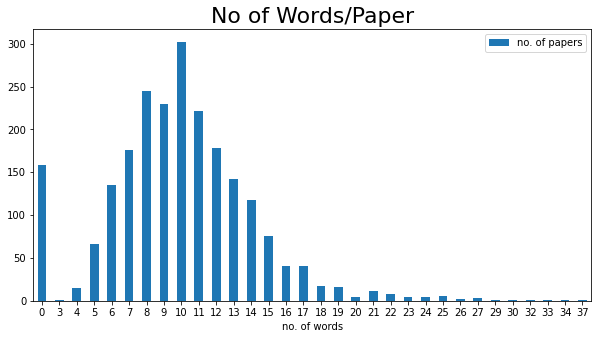

In [18]:
no_words = [len(words) for words in processed_corpus]
x = list(set(no_words))
_ = [no_words.count(tmp) for tmp in x]
df = pd.DataFrame({'no. of words': x, 'no. of papers':_})
ax = df.plot.bar(x='no. of words', y='no. of papers', rot=0, figsize=(10, 5))
plt.title("No of Words/Paper", fontsize=22)
#plt.savefig('words.png')

In [19]:
from collections import Counter

# Find most common words
c = Counter()
clustered_papers['words'].apply(c.update)
print(c.most_common(20))

[('learn', 890), ('model', 525), ('kernel', 304), ('optimization', 297), ('method', 255), ('network', 242), ('classification', 241), ('bayesian', 225), ('machine', 215), ('analysis', 204), ('regression', 200), ('process', 184), ('selection', 182), ('graph', 169), ('matrix', 167), ('datum', 165), ('inference', 163), ('algorithm', 158), ('linear', 140), ('vector', 136)]


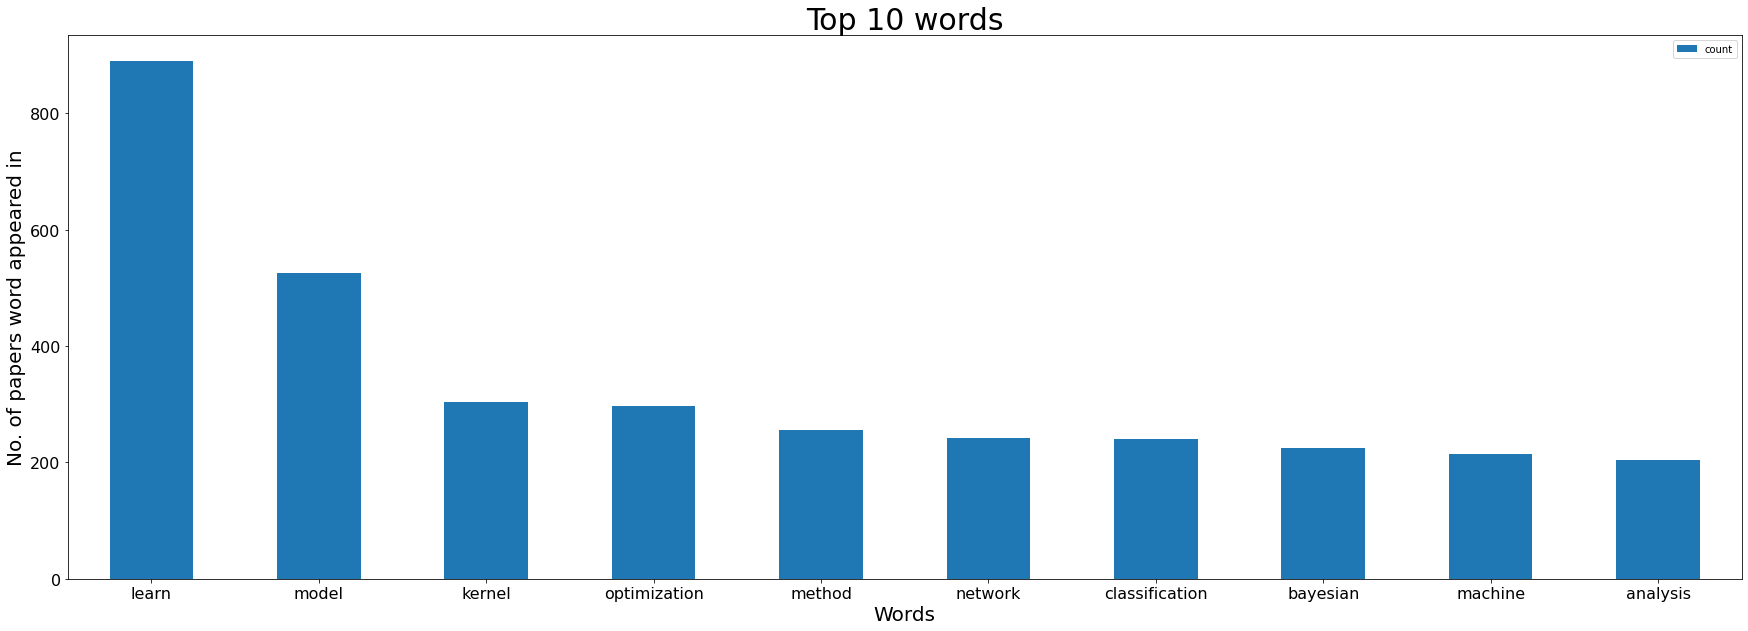

In [20]:
from matplotlib import ticker as mticker


# %%
df_counter_words = pd.DataFrame.from_dict(c, orient='index').reset_index()
df_counter_words = df_counter_words.rename(columns={'index':'word', 0:'count'})
top_words = df_counter_words.nlargest(10, "count")

top_plot = top_words.plot.bar(x='word', y='count', rot=0, fontsize= 16, figsize= (30, 10))
top_plot.set_xlabel("Words", fontsize= 20)
top_plot.set_ylabel("No. of papers word appeared in", fontsize= 20)
top_plot.set_title("Top 10 words", fontsize= 30)
top_plot.yaxis.set_major_formatter(mticker.ScalarFormatter())
top_plot.yaxis.get_major_formatter().set_scientific(False)
#plt.savefig(Path(output_directory +"words.png"))


In [21]:

# %%
top_40_words = df_counter_words.nlargest(40, 'count')

def count_words_paper(text):
    return len(list(set(text).intersection(list(top_40_words['word']))))

top_words_paper = clustered_papers['words'].apply(count_words_paper)


In [22]:
for i in range(max(top_words_paper + 1)):
    if i == max(top_words_paper):
        print("\nmax no. of words from top 40 present in a single paper is {}".format(max(top_words_paper)))
    print("{} papers have {} words from top 40".format(len(top_words_paper[top_words_paper == i]), i))

248 papers have 0 words from top 40
314 papers have 1 words from top 40
474 papers have 2 words from top 40
439 papers have 3 words from top 40
335 papers have 4 words from top 40
228 papers have 5 words from top 40
113 papers have 6 words from top 40
51 papers have 7 words from top 40
15 papers have 8 words from top 40
4 papers have 9 words from top 40
7 papers have 10 words from top 40
0 papers have 11 words from top 40
1 papers have 12 words from top 40
0 papers have 13 words from top 40

max no. of words from top 40 present in a single paper is 14
1 papers have 14 words from top 40


(-0.5, 399.5, 199.5, -0.5)

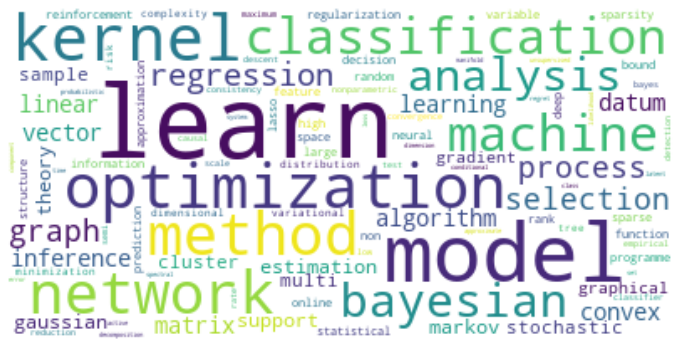

In [23]:
from wordcloud import WordCloud

joined_text = " ".join(clustered_papers.words.str.join(" ").tolist())

wordcloud = WordCloud(max_font_size=60, max_words=100, background_color="white", collocations=False).generate(joined_text)

fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.savefig(Path(output_directory + "top_keywords_wordcloud.png"))

In [24]:
vals = []

list_unique_labels = list(unique_labels)
for i in range(len(list_unique_labels)):
    _ = clustered_papers['words'][clustered_papers['cluster'] == list_unique_labels[i]].tolist()
    _ = [word for sublist in _ for word in sublist]
    vals.append(set(_))

words_label = pd.DataFrame({'words_set': vals, 'cluster': list_unique_labels}, columns = ['words_set', 'cluster'])

In [25]:
for index, row in words_label.iterrows():
    print("cluster {} contains {} unique words".format(row['cluster'], len(row['words_set'])))

cluster 0 contains 51 unique words
cluster 1 contains 72 unique words
cluster 2 contains 913 unique words
cluster 3 contains 25 unique words
cluster 4 contains 95 unique words
cluster 5 contains 30 unique words
cluster 6 contains 51 unique words
cluster 7 contains 10 unique words
cluster 8 contains 12 unique words
cluster 9 contains 35 unique words
cluster 10 contains 18 unique words
cluster 11 contains 123 unique words
cluster 12 contains 38 unique words
cluster 13 contains 23 unique words
cluster 14 contains 14 unique words
cluster 15 contains 32 unique words
cluster 16 contains 23 unique words
cluster 17 contains 30 unique words
cluster 18 contains 17 unique words
cluster 19 contains 19 unique words
cluster 20 contains 20 unique words
cluster 21 contains 34 unique words
cluster 22 contains 15 unique words
cluster 23 contains 18 unique words
cluster 24 contains 14 unique words
cluster 25 contains 19 unique words
cluster 26 contains 16 unique words
cluster 27 contains 13 unique words


In [26]:
import itertools

common_words = []
common_words_no = []

for index, row in words_label.iterrows():
    cw_row = []
    cw_row_no = []
    for index_2, row_2 in words_label.iterrows():
        wset = list(set(row['words_set']).intersection(set(row_2['words_set'])))
        cw_row.append(wset)
        cw_row_no.append(len(wset))
    common_words.append(cw_row)
    common_words_no.append(cw_row_no)

In [27]:
print(common_words_no)

[[51, 7, 30, 6, 4, 5, 7, 3, 1, 7, 2, 12, 6, 3, 5, 6, 6, 5, 2, 1, 2, 4, 2, 0, 1, 3, 0, 1, 2, 3, 2, 1, 2, 2, 3, 4, 2, 5, 44], [7, 72, 42, 2, 13, 5, 5, 2, 0, 13, 2, 16, 3, 1, 3, 2, 2, 3, 0, 2, 1, 3, 1, 0, 3, 2, 1, 0, 0, 1, 3, 2, 0, 2, 2, 0, 1, 2, 62], [30, 42, 913, 17, 52, 19, 38, 8, 9, 24, 7, 75, 28, 16, 13, 21, 17, 23, 13, 17, 14, 26, 11, 13, 9, 14, 12, 6, 11, 10, 13, 26, 17, 7, 19, 13, 13, 12, 702], [6, 2, 17, 25, 4, 3, 6, 1, 1, 4, 0, 9, 3, 1, 3, 4, 1, 4, 1, 0, 1, 2, 2, 0, 2, 2, 0, 0, 2, 1, 3, 0, 0, 2, 2, 4, 2, 1, 19], [4, 13, 52, 4, 95, 6, 10, 4, 0, 8, 0, 17, 3, 3, 2, 1, 2, 10, 4, 4, 2, 6, 5, 1, 0, 7, 3, 1, 4, 3, 3, 6, 6, 1, 4, 3, 1, 1, 81], [5, 5, 19, 3, 6, 30, 5, 1, 1, 4, 1, 8, 2, 2, 2, 2, 1, 5, 1, 1, 2, 3, 2, 0, 1, 2, 1, 1, 1, 2, 3, 2, 0, 0, 2, 3, 2, 3, 24], [7, 5, 38, 6, 10, 5, 51, 2, 2, 7, 0, 13, 8, 4, 4, 3, 1, 10, 3, 6, 3, 6, 8, 2, 0, 7, 1, 2, 1, 4, 5, 9, 5, 1, 5, 8, 3, 3, 47], [3, 2, 8, 1, 4, 1, 2, 10, 0, 2, 0, 3, 0, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 0, 1, 1, 0, 0, 1, 2, 0, 1, 2, 1

In [33]:
clustered_papers['cluster'].value_counts(sort=True, ascending=True)


 25       3
 36       3
 7        3
 23       3
 30       3
 27       3
 26       3
 24       3
 22       3
 35       3
 20       3
 16       3
 14       3
 13       3
 10       3
 8        3
 19       3
 33       3
 18       3
 29       3
 21       4
 37       4
 34       4
 28       4
 31       4
 3        4
 32       4
 17       5
 15       6
 5        7
 12       7
 6        9
 9       10
 0       13
 1       14
 4       23
 11      35
 2      429
-1     1584
Name: cluster, dtype: int64